# Assess Replicate Correlation

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggridges))

In [2]:
set.seed(123)

## Step 0: Load Constants

In [3]:
batch_id <- "2019_06_11_Batch2"
backend_dir <- file.path("..", "..", "backend", batch_id)

## Step 1: Read in Normalized Profiles

In [4]:
profile_files <- list.files(backend_dir,
                            full.names = TRUE,
                            recursive = TRUE,
                            pattern = "_variable_selected.csv")

In [5]:
profile_cols <- readr::cols(
  .default = readr::col_double(),
  Metadata_Plate = readr::col_character(),
  Metadata_Well = readr::col_character(),
  Metadata_Assay_Plate_Barcode = readr::col_character(),
  Metadata_Plate_Map_Name = readr::col_character(),
  Metadata_well_position = readr::col_character(),
  Metadata_cell_line = readr::col_character(),
  Metadata_condition_O2 = readr::col_character()
)

In [6]:
profile_df <- purrr::map_df(
    profile_files,
    readr::read_csv,
    col_types = readr::cols()
)

dim(profile_df)
head(profile_df, 2)

[1] 312 453

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_condition_O2,Metadata_treatment,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,⋯,Nuclei_Texture_SumAverage_AGP_20_02,Nuclei_Texture_SumAverage_ER_20_00,Nuclei_Texture_SumAverage_Mito_20_01,Nuclei_Texture_SumEntropy_DNA_5_02,Nuclei_Texture_SumVariance_AGP_10_03,Nuclei_Texture_SumVariance_DNA_10_01,Nuclei_Texture_SumVariance_DNA_20_00,Nuclei_Texture_SumVariance_DNA_20_03,Nuclei_Texture_SumVariance_Mito_20_03,Nuclei_Texture_SumVariance_Mito_5_02
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BR00101066,B02,BR00101066,BR00101066,B02,SNU761,21,OA,0.8518903,-6.002905,⋯,-0.3544770,0.3258979,-1.2097912,-1.002227,0.3040175,-0.4410628,-1.4939664,-1.2564229,-0.87587934,-0.8966755
BR00101066,B03,BR00101066,BR00101066,B03,SNU761,21,PA,-0.5263011,-0.216030,⋯,-0.6102905,-0.5211336,-0.6602421,1.687832,0.8678467,1.3680409,0.4538432,-0.5158449,0.04255897,0.6954802


In [7]:
# Output Combined Profiles
file <- file.path("data", paste0("merged_profiles_", batch_id, ".tsv.gz"))
readr::write_tsv(profile_df, file)

## Step 2: Extract Pairwise Correlations

In [8]:
# Separate different cell profiler data
cp_features <- colnames(profile_df) %>%
    stringr::str_subset("^Nuclei_|^Cells_|^Cytoplasm_")

length(cp_features)

cp_metadata <- colnames(profile_df) %>%
    stringr::str_subset("^Metadata_")

length(cp_metadata)

[1] 445

[1] 8

In [9]:
# Create a metadata dictionary and dummy variable "group_id"
# "group_id" distinguishes each separate condition including cell line
# "condition_group_id" distinguishes separate conditions ignoring cell line
metadata_df <- profile_df %>%
    dplyr::select(cp_metadata) %>%
    dplyr::mutate(dictionary_id = paste0("id_", dplyr::row_number()),
                  group_id = group_indices(.,
                                           Metadata_cell_line,
                                           Metadata_condition_O2,
                                           Metadata_treatment))

tail(metadata_df)

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_condition_O2,Metadata_treatment,dictionary_id,group_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
BR00101179,H07,BR00101179,BR00101179,H07,SNU761,21,Metformin,id_307,15
BR00101179,H08,BR00101179,BR00101179,H08,SNU761,21,Rosuv,id_308,22
BR00101179,H09,BR00101179,BR00101179,H09,SNU761,21,Pita,id_309,20
BR00101179,H10,BR00101179,BR00101179,H10,SNU761,21,DMOG,id_310,13
BR00101179,H11,BR00101179,BR00101179,H11,SNU761,21,DMSO,id_311,14
BR00101179,H12,BR00101179,BR00101179,H12,SNU761,21,plus_serum,id_312,21


## Metadata Description

* `Cell Line`
  * `SNU761` - Hepatacellular Carcinoma Line
* `Metadata_condition_O2`
  * `4` - Low exposure to O2
  * `21` - High exposure to O2
* `Metadata_treatment`
  * `BSA`
  * `Metformin`
  * `Rosuv`
  * `Pita`
  * `DMOG`
  * `DMSO`
  * `plus_serum`
  * `no_serum`
  * `OA`
  * `OA_PA`
  * `PA`

In [10]:
table(
    metadata_df$Metadata_Plate,
    metadata_df$Metadata_treatment,
    metadata_df$Metadata_condition_O2,
    metadata_df$Metadata_cell_line
)

, ,  = 4,  = SNU761

            
             BSA DMOG DMSO Metformin no_serum OA OA_PA PA Pita plus_serum Rosuv
  BR00101066   0    0    0         0        0  0     0  0    0          0     0
  BR00101067   6    6    0         6        6  6     6  6    6          6     6
  BR00101178   8    8   16         8        8  8     8  8    8          8     8
  BR00101179   0    0    0         0        0  0     0  0    0          0     0

, ,  = 21,  = SNU761

            
             BSA DMOG DMSO Metformin no_serum OA OA_PA PA Pita plus_serum Rosuv
  BR00101066   6    6    0         6        6  6     6  6    6          6     6
  BR00101067   0    0    0         0        0  0     0  0    0          0     0
  BR00101178   0    0    0         0        0  0     0  0    0          0     0
  BR00101179   8    8   16         8        8  8     8  8    8          8     8


In [11]:
# Create a dataframe of variables for each group
group_id_df <- metadata_df %>%
    dplyr::select(
        group_id,
        Metadata_cell_line,
        Metadata_condition_O2,
        Metadata_treatment
    ) %>%
    dplyr::distinct() %>%
    dplyr::arrange(group_id)

dim(group_id_df)
head(group_id_df)

[1] 22  4

group_id,Metadata_cell_line,Metadata_condition_O2,Metadata_treatment
<int>,<chr>,<int>,<chr>
1,SNU761,4,BSA
2,SNU761,4,DMOG
3,SNU761,4,DMSO
4,SNU761,4,Metformin
5,SNU761,4,no_serum
6,SNU761,4,OA


## Step 3: Get Correlations

In [12]:
cor_df <- profile_df %>%
    dplyr::select(cp_features) %>%
    t() %>%
    cor() %>%
    dplyr::as_tibble() %>%
    magrittr::set_colnames(metadata_df$dictionary_id)

cor_melt_df <- metadata_df %>%
    dplyr::select(-group_id) %>%
    dplyr::bind_cols(
        replace(cor_df,
                lower.tri(cor_df, TRUE), NA)
    ) %>%
    dplyr::select(-cp_metadata) %>%
    reshape2::melt(id.vars = 'dictionary_id',
                   variable.name = 'correlation_id', 
                   value.name = "pearson_cor",
                   na.rm = TRUE) %>%
    tibble::remove_rownames()

dim(cor_melt_df)
head(cor_melt_df)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

[1] 48516     3

dictionary_id,correlation_id,pearson_cor
<chr>,<fct>,<dbl>
id_1,id_2,-0.071892154
id_1,id_3,-0.064393700
id_2,id_3,-0.162414683
id_1,id_4,-0.010269407
id_2,id_4,-0.053226948
id_3,id_4,-0.007796069


In [13]:
# Map group IDs and condition IDs onto the correlation dataframe
# We are interested in correlations between specific groups
cor_group_df <- cor_melt_df %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id),
        by = 'dictionary_id'
    ) %>%
    dplyr::rename(pair_a = group_id) %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id),
        by = c('correlation_id' = 'dictionary_id')
    ) %>%
    dplyr::rename(pair_b = group_id,
                  pair_a_id = dictionary_id,
                  pair_b_id = correlation_id)

dim(cor_group_df)
head(cor_group_df)

Warning message:
“Column `correlation_id`/`dictionary_id` joining factor and character vector, coercing into character vector”

[1] 48516     5

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b
<chr>,<chr>,<dbl>,<int>,<int>
id_1,id_2,-0.071892154,17,19
id_1,id_3,-0.064393700,17,18
id_2,id_3,-0.162414683,19,18
id_1,id_4,-0.010269407,17,16
id_2,id_4,-0.053226948,19,16
id_3,id_4,-0.007796069,18,16


In [14]:
# Remove self correlations and determine median correlation between all groups
# Also create a variable that represents correlations across cell lines within
# the same condition. This variable will be used as the null distribution.
cor_group_df <- cor_group_df %>%
    dplyr::mutate(
        within_group_cor =
            as.numeric(cor_group_df$pair_a == cor_group_df$pair_b),
    ) %>%
    dplyr::filter(cor_group_df$pair_a_id != cor_group_df$pair_b_id) %>%
    dplyr::group_by(
        pair_a,
        pair_b
    ) %>%
    dplyr::mutate(median_cor = median(pearson_cor)) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(median_cor))

dim(cor_group_df)
head(cor_group_df)

[1] 48516     7

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
id_122,id_132,0.3191160,3,5,0,0.8183701
id_131,id_132,0.4784748,3,5,0,0.8183701
id_122,id_144,0.6729339,3,5,0,0.8183701
id_131,id_144,0.7979264,3,5,0,0.8183701
id_134,id_144,0.7295059,3,5,0,0.8183701
id_143,id_144,0.8226739,3,5,0,0.8183701


In [15]:
# Join Replicate Correlations and Null Distribution Correlations
within_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_cor == 1) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Replicate Correlation") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

null_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_cor == 0) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Non Replicate Correlation") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

full_plot_ready <- within_group_cor_df %>%
    dplyr::bind_rows(
        null_group_cor_df
    )

dim(full_plot_ready)
head(full_plot_ready)

[1] 48516     9

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor,pair_b_median_cor,null_data
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
id_122,id_131,0.8861057,3,3,1,0.8075345,0.8075345,Replicate Correlation
id_122,id_134,0.9459393,3,3,1,0.8075345,0.8075345,Replicate Correlation
id_131,id_134,0.8872209,3,3,1,0.8075345,0.8075345,Replicate Correlation
id_122,id_143,0.7714632,3,3,1,0.8075345,0.8075345,Replicate Correlation
id_131,id_143,0.8024745,3,3,1,0.8075345,0.8075345,Replicate Correlation
id_134,id_143,0.8041720,3,3,1,0.8075345,0.8075345,Replicate Correlation


## Step 4: Generate Figures

In [16]:
# Merge plot ready data with info on group ID
full_plot_ready <- full_plot_ready %>%
    dplyr::left_join(group_id_df, by = c("pair_b" = "group_id"))

head(full_plot_ready, 2)

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor,pair_b_median_cor,null_data,Metadata_cell_line,Metadata_condition_O2,Metadata_treatment
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
id_122,id_131,0.8861057,3,3,1,0.8075345,0.8075345,Replicate Correlation,SNU761,4,DMSO
id_122,id_134,0.9459393,3,3,1,0.8075345,0.8075345,Replicate Correlation,SNU761,4,DMSO


In [17]:
# Update Factors for plotting
full_plot_ready$Metadata_condition_O2 <-
    factor(full_plot_ready$Metadata_condition_O2,
           levels = c("4", "21"))

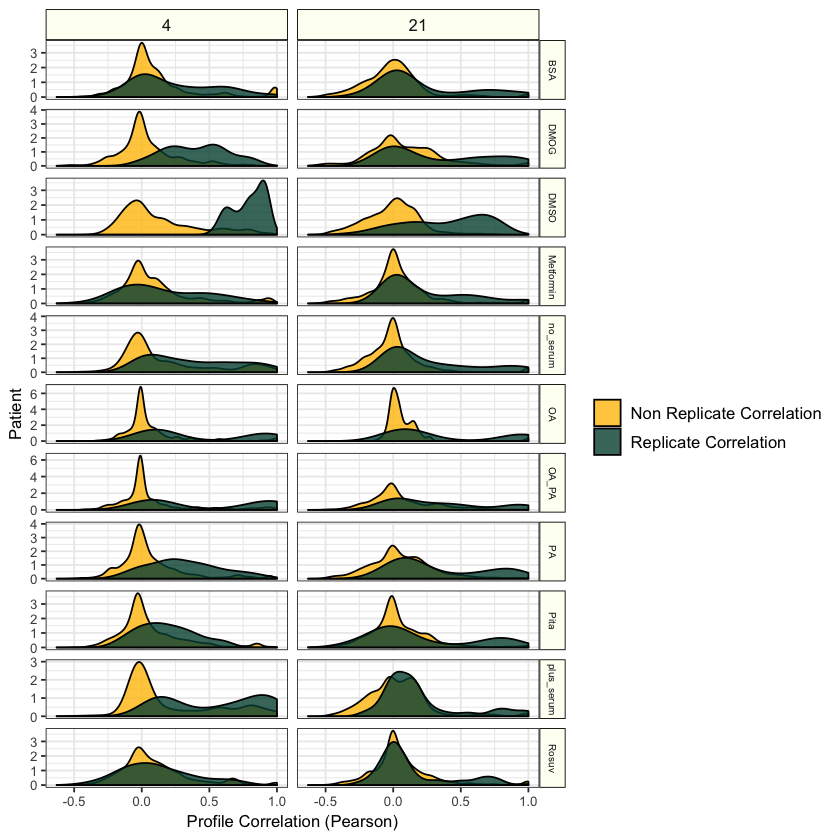

In [18]:
cor_gg <- ggplot(full_plot_ready,
                 aes(x = pearson_cor,
                     fill = null_data)) +
    geom_density(alpha = 0.8) +
    ylab("Patient") +
    xlab("Profile Correlation (Pearson)") +
    theme_bw() +
    facet_grid(Metadata_treatment~Metadata_condition_O2,
               scales="free_y") +
    scale_fill_manual(name = "",
                      values = c("#FFC107", "#004D40")) +
    theme(axis.text.y = element_text(size = 8),
          axis.text.x = element_text(size = 8),
          axis.title = element_text(size = 10),
          legend.text = element_text(size = 10),
          strip.text.x = element_text(size = 10),
          strip.text.y = element_text(size = 6),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

print(cor_gg)

In [19]:
file_base <- file.path("figures", paste0("replicate_correlation_batch_", batch_id))
for (extension in c('.png', '.pdf')) {
    ggsave(cor_gg,
           filename = paste0(file_base, extension),
           height = 10,
           width = 8)
}

## Step 5: Perform KS Test Against Distributions

In [20]:
# Perform KS tests between real and null distributions
all_results <- list()
for (group_id in unique(full_plot_ready$pair_b)) {
    full_plot_group_df = full_plot_ready %>%
        dplyr::filter(pair_b == group_id)

    replicate_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_cor == 1)
    null_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_cor == 0)

    ks_result = ks.test(x = replicate_corr_df$pearson_cor,
                        y = null_corr_df$pearson_cor,
                        alternative = "less")

    k_stat = as.numeric(ks_result$statistic)
    k_p = as.numeric(ks_result$p.value)
    all_results[[group_id]] <- c(group_id, k_stat, k_p, -log10(k_p), nrow(replicate_corr_df))
}

ks_result_df <- dplyr::as_tibble(do.call(rbind, all_results))
colnames(ks_result_df) <- c("group_id", "ks_stat", "ks_p_value", "ks_log_10_p", "num_replicates")

ks_result_df <- ks_result_df %>% dplyr::arrange(desc(as.numeric(paste(ks_log_10_p))))

dim(ks_result_df)
head(ks_result_df)

[1] 22  5

group_id,ks_stat,ks_p_value,ks_log_10_p,num_replicates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.8673177,1.271317e-75,74.89575,120
14,0.5963216,9.785665e-37,36.00941,120
2,0.6686166,2.132816e-34,33.67105,91
10,0.5717367,2.613944e-25,24.58270,91
7,0.5685048,5.134815e-25,24.28948,91
8,0.5245316,2.142339e-21,20.66911,91


In [21]:
ks_result_df$group_id <- as.numeric(ks_result_df$group_id)

final_results_df <- full_plot_ready %>%
    dplyr::left_join(ks_result_df,
                     by = c("pair_b" = "group_id")) %>%
    dplyr::group_by(
        Metadata_cell_line,
        Metadata_condition_O2,
        Metadata_treatment
    ) %>%
    dplyr::mutate(
        median_cell_ks = median(ks_stat)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(
        Metadata_cell_line,
        Metadata_condition_O2,
        Metadata_treatment,
        ks_stat,
        ks_p_value
    ) %>%
    dplyr::distinct()

head(final_results_df, 2)

Metadata_cell_line,Metadata_condition_O2,Metadata_treatment,ks_stat,ks_p_value
<chr>,<fct>,<chr>,<dbl>,<dbl>
SNU761,4,DMSO,0.8673177,1.271317e-75
SNU761,4,plus_serum,0.5717367,2.613944e-25


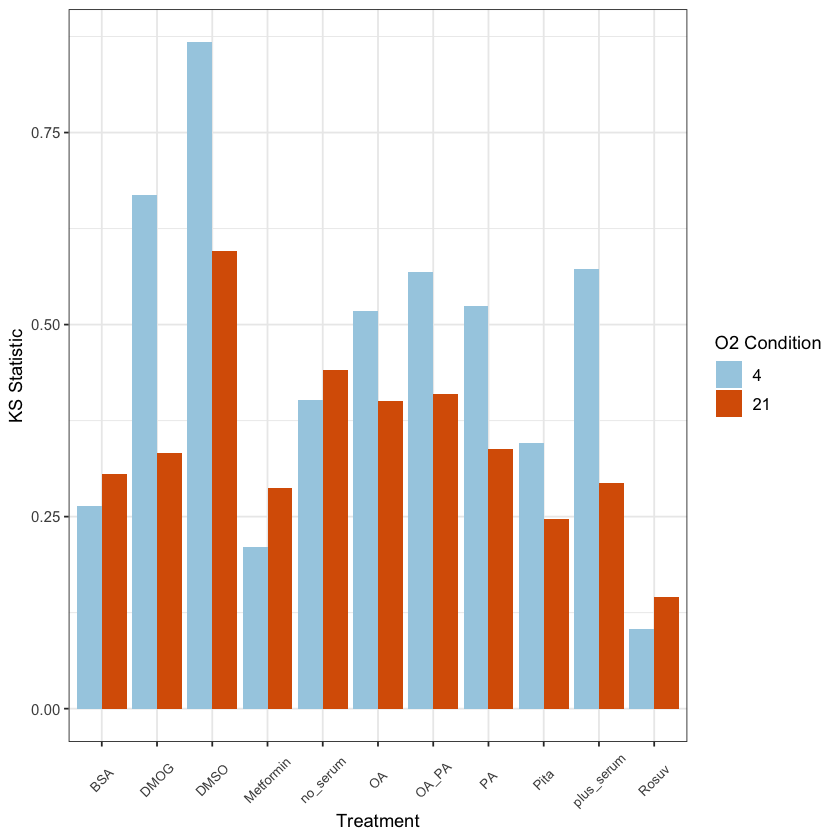

In [22]:
ks_test_gg <- ggplot(final_results_df) +
    geom_bar(aes(y = ks_stat,
                 x = as.factor(Metadata_treatment),
                 fill = Metadata_condition_O2),
                stat = "identity",
            position = "dodge") +
    xlab("Treatment") +
    ylab("KS Statistic") +
    scale_fill_manual(name = "O2 Condition",
                       values = c("4" = "#a6cee3", "21" = "#d95f02"),
                       labels = c("4" = "4", "21" = "21")) +
    theme_bw() +
    theme(axis.text.y = element_text(size = 9),
          axis.text.x = element_text(size = 8,
                                     angle = 45,
                                     vjust = 0.5),
          axis.title = element_text(size = 11),
          legend.text = element_text(size = 10),
          strip.text = element_text(size = 9),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

ks_test_gg

In [23]:
file_base <- file.path("figures", paste0("replicate_correlation_kstest", "_", batch_id))
for (extension in c('.png', '.pdf')) {
    ggsave(ks_test_gg,
           filename = paste0(file_base, extension),
           height = 4,
           width = 6)
}